# F20AA Coursework 2

In [1]:
import googleapiclient.discovery
import googleapiclient.errors
import numpy as np
import pandas as pd
import glob
import nltk 
import os
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
from langdetect import detect
import shutil
import random
from wordcloud import WordCloud
import seaborn as sns
from textblob import TextBlob
from tabulate import tabulate
from sklearn.model_selection import GridSearchCV 
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.datasets import load_files
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

nltk.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/fayazbadubhai/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fayazbadubhai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1) Data Exploration and Visualization:

In [2]:
train_df = pd.read_csv('train.csv.zip')
test_df = pd.read_csv('test.csv.zip')

In [3]:
train_df.shape

(370863, 2)

In [4]:
train_df.head()

,overall,Review
0,5,I love these glitter pens. They sparkle deligh...
1,5,It works well with my machine. I use mostly c...
2,5,"This is a great assortment of colors, though t..."
3,5,Just what I was looking for.
4,5,I make 400 birds for the hospital each month.


In [5]:
train_df.isna().any().any()

True

In [6]:
# Check for null values in the DataFrame
null_values = train_df.isnull().sum()
print(null_values)

overall    0
Review     8
dtype: int64


In [7]:
# Filter rows with at least one null value
rows_with_null = train_df[train_df.isnull().any(axis=1)]

# Print the rows with null values
print("Rows with null values:")
print(rows_with_null)

Rows with null values:
        overall Review
26709         5    NaN
140678        4    NaN
149137        5    NaN
161123        5    NaN
199465        5    NaN
309619        5    NaN
328716        5    NaN
337056        5    NaN


In [8]:
# Drop rows with null values
train_df = train_df.dropna()

In [9]:
# Filter rows with at least one null value
rows_with_null = train_df[train_df.isnull().any(axis=1)]

# Print the rows with null values
print("Rows with null values:")
print(rows_with_null)

Rows with null values:
Empty DataFrame
Columns: [overall, Review]
Index: []


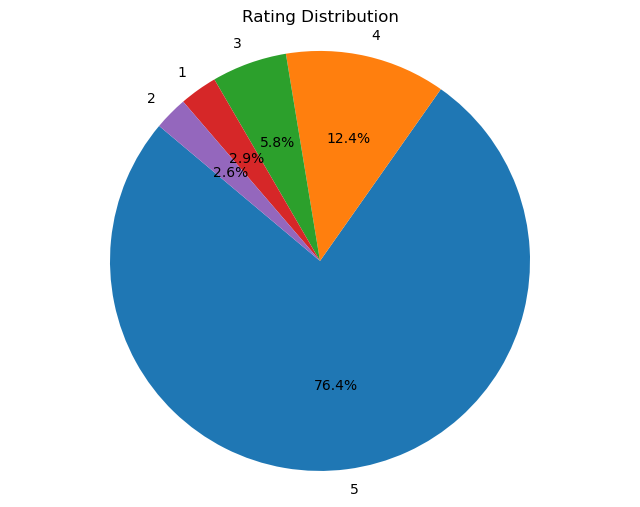

In [10]:
review_distribution = train_df['overall'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(review_distribution, labels=review_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Rating Distribution')
plt.axis('equal')
plt.show()

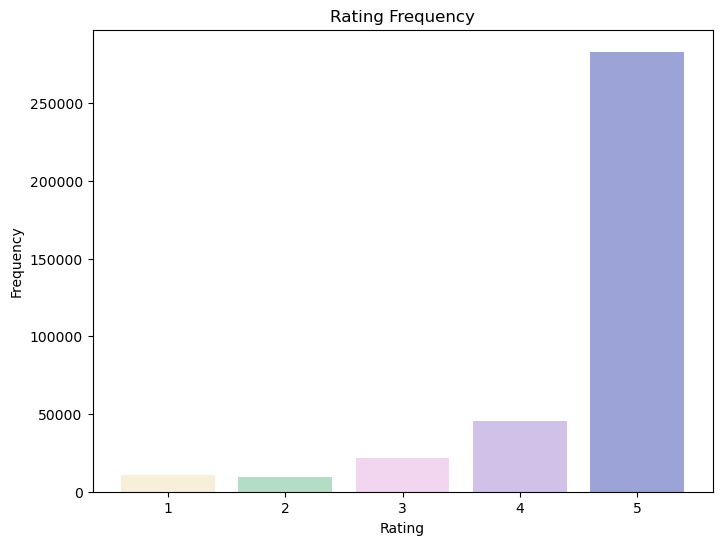

In [11]:
plt.figure(figsize=(8, 6))
# color=['#9CA3D6','#CFC1E8', '#F2D5EF', '#F7EFDA', '#B3DDC4']
plt.bar(review_distribution.index, review_distribution.values, color=['#9CA3D6','#CFC1E8', '#F2D5EF', '#F7EFDA', '#B3DDC4'])
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Rating Frequency')
plt.show()

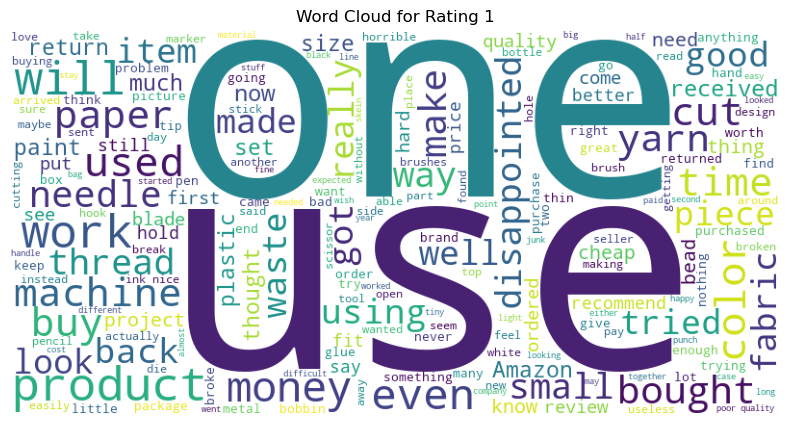

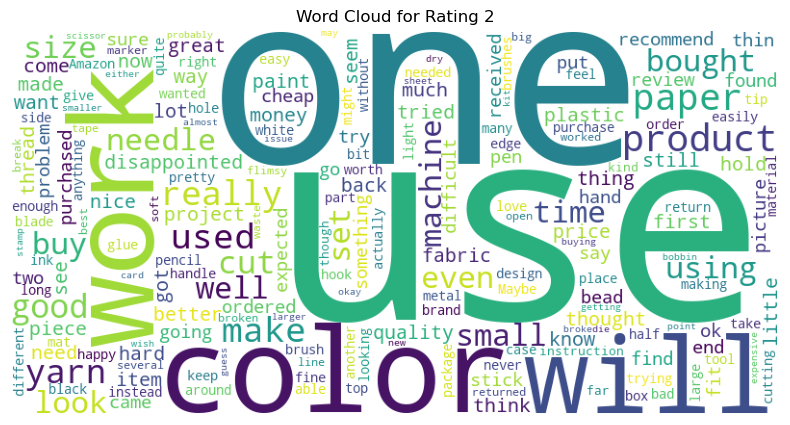

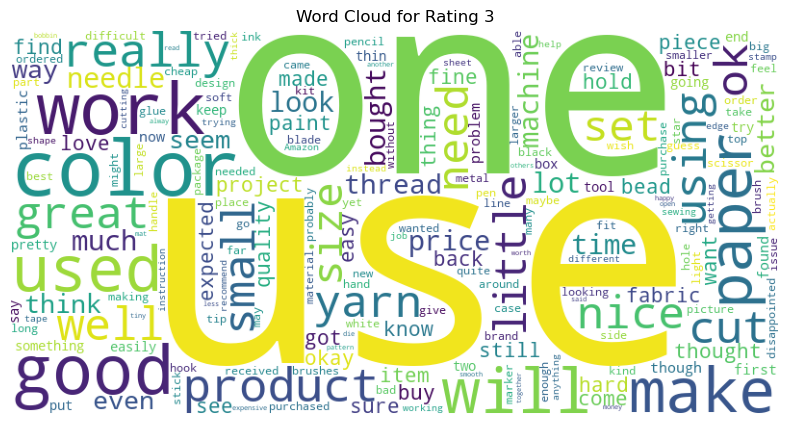

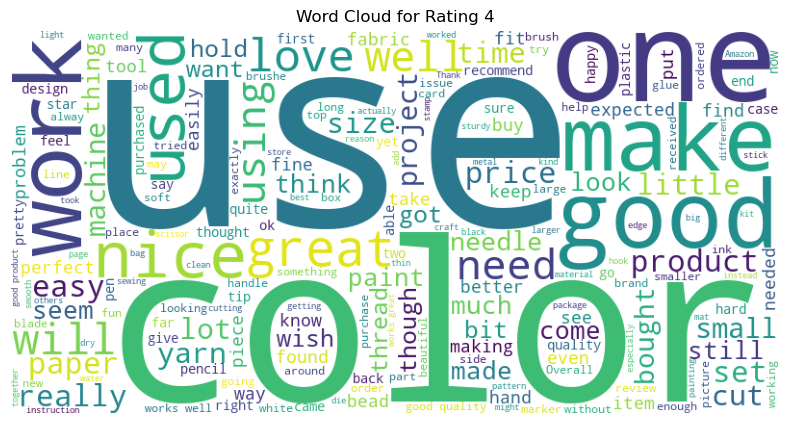

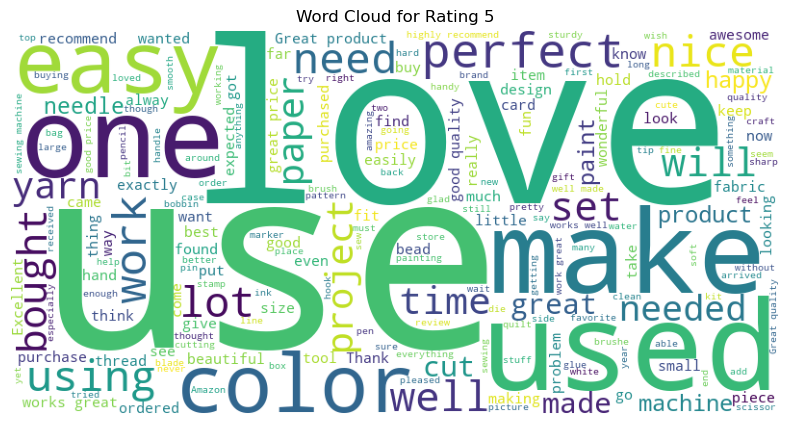

In [12]:
# Grouped in descending order
grouped = train_df.groupby('overall')

# Generate word cloud for each rating
for rating, group in grouped:
    text = ' '.join(group['Review'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    # Plot word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.title(f'Word Cloud for Rating {rating}')
    plt.axis('off')
    plt.show()

In [13]:
# train_df['text_length'] = train_df['Review'].apply(len)

# plt.figure(figsize=(10, 6))
# sns.boxplot(x='overall', y='text_length', data=train_df)
# plt.title('Length of Text for Each Rating')
# plt.xlabel('Rating')
# plt.ylabel('Text Length')
# plt.show()

## 2) Text Processing and Normalization:

In [14]:
def remove_punctuation(text):
    # Define the pattern to match punctuation
    punctuation_pattern = r'[^\w\s]'
    # Replace punctuation with an empty string
    text_without_punctuation = re.sub(punctuation_pattern, '', text)
    # Normalize whitespace
    normalized_text = re.sub(r'\s+', ' ', text_without_punctuation)
    return normalized_text

# Text Processing
def preprocess_text(text, method='snowballstemming'):
    # Tokenize and lowercase
    tokens = word_tokenize(text.lower())

    # Define the set of stopwords
    stop_words = set(stopwords.words('english'))
    
    # Remove stopwords and punctuation
    tokens = [remove_punctuation(token) for token in tokens if token.isalnum() and token not in stop_words]
    
    if method == 'snowballstemming':
        stemmer = nltk.stem.SnowballStemmer('english')
        tokens = [stemmer.stem(token) for token in tokens]

    elif method == 'porterstemming':
        stemmer = nltk.stem.PorterStemmer()
        tokens = [stemmer.stem(token) for token in tokens]

    elif method == 'lemmatization':
        lemmatizer = nltk.stem.WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)

In [15]:
train_df['ssprocessing_text'] = train_df['Review'].apply(preprocess_text, method='snowballstemming')
train_df['psprocessing_text'] = train_df['Review'].apply(preprocess_text, method='porterstemming')
train_df['lemprocessing_text'] = train_df['Review'].apply(preprocess_text, method='lemmatization')

In [16]:
train_df

,overall,Review,ssprocessing_text,psprocessing_text,lemprocessing_text
0,5,I love these glitter pens. They sparkle deligh...,love glitter pen sparkl delight page brilliant...,love glitter pen sparkl delight page brilliant...,love glitter pen sparkle delightfully page bri...
1,5,It works well with my machine. I use mostly c...,work well machin use most cone,work well machin use mostli cone,work well machine use mostly cone
2,5,"This is a great assortment of colors, though t...",great assort color though lot pink mix still c...,great assort color though lot pink mix still c...,great assortment color though lot pink mix sti...
3,5,Just what I was looking for.,look,look,looking
4,5,I make 400 birds for the hospital each month.,make 400 bird hospit month,make 400 bird hospit month,make 400 bird hospital month
...,...,...,...,...,...
370858,5,I love these dies they make great backgrounds ...,love die make great background card,love die make great background card,love dy make great background card
370859,5,I love Darice embossing folders. Darcie's fol...,love daric emboss folder darci folder reason e...,love daric emboss folder darci folder reason e...,love darice embossing folder darcie folder rea...
370860,5,I ordered these to add to my Earthy Markers th...,order add earthi marker previous order want br...,order add earthi marker previous order want br...,ordered add earthy marker previously ordered w...
370861,4,Made perfect off white color by blending a tin...,made perfect white color blend tini amount yel...,made perfect white color blend tini amount yel...,made perfect white color blending tiny amount ...
